In [1]:
%%javascript
// Disables truncation of output window
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from IPython.display import Image

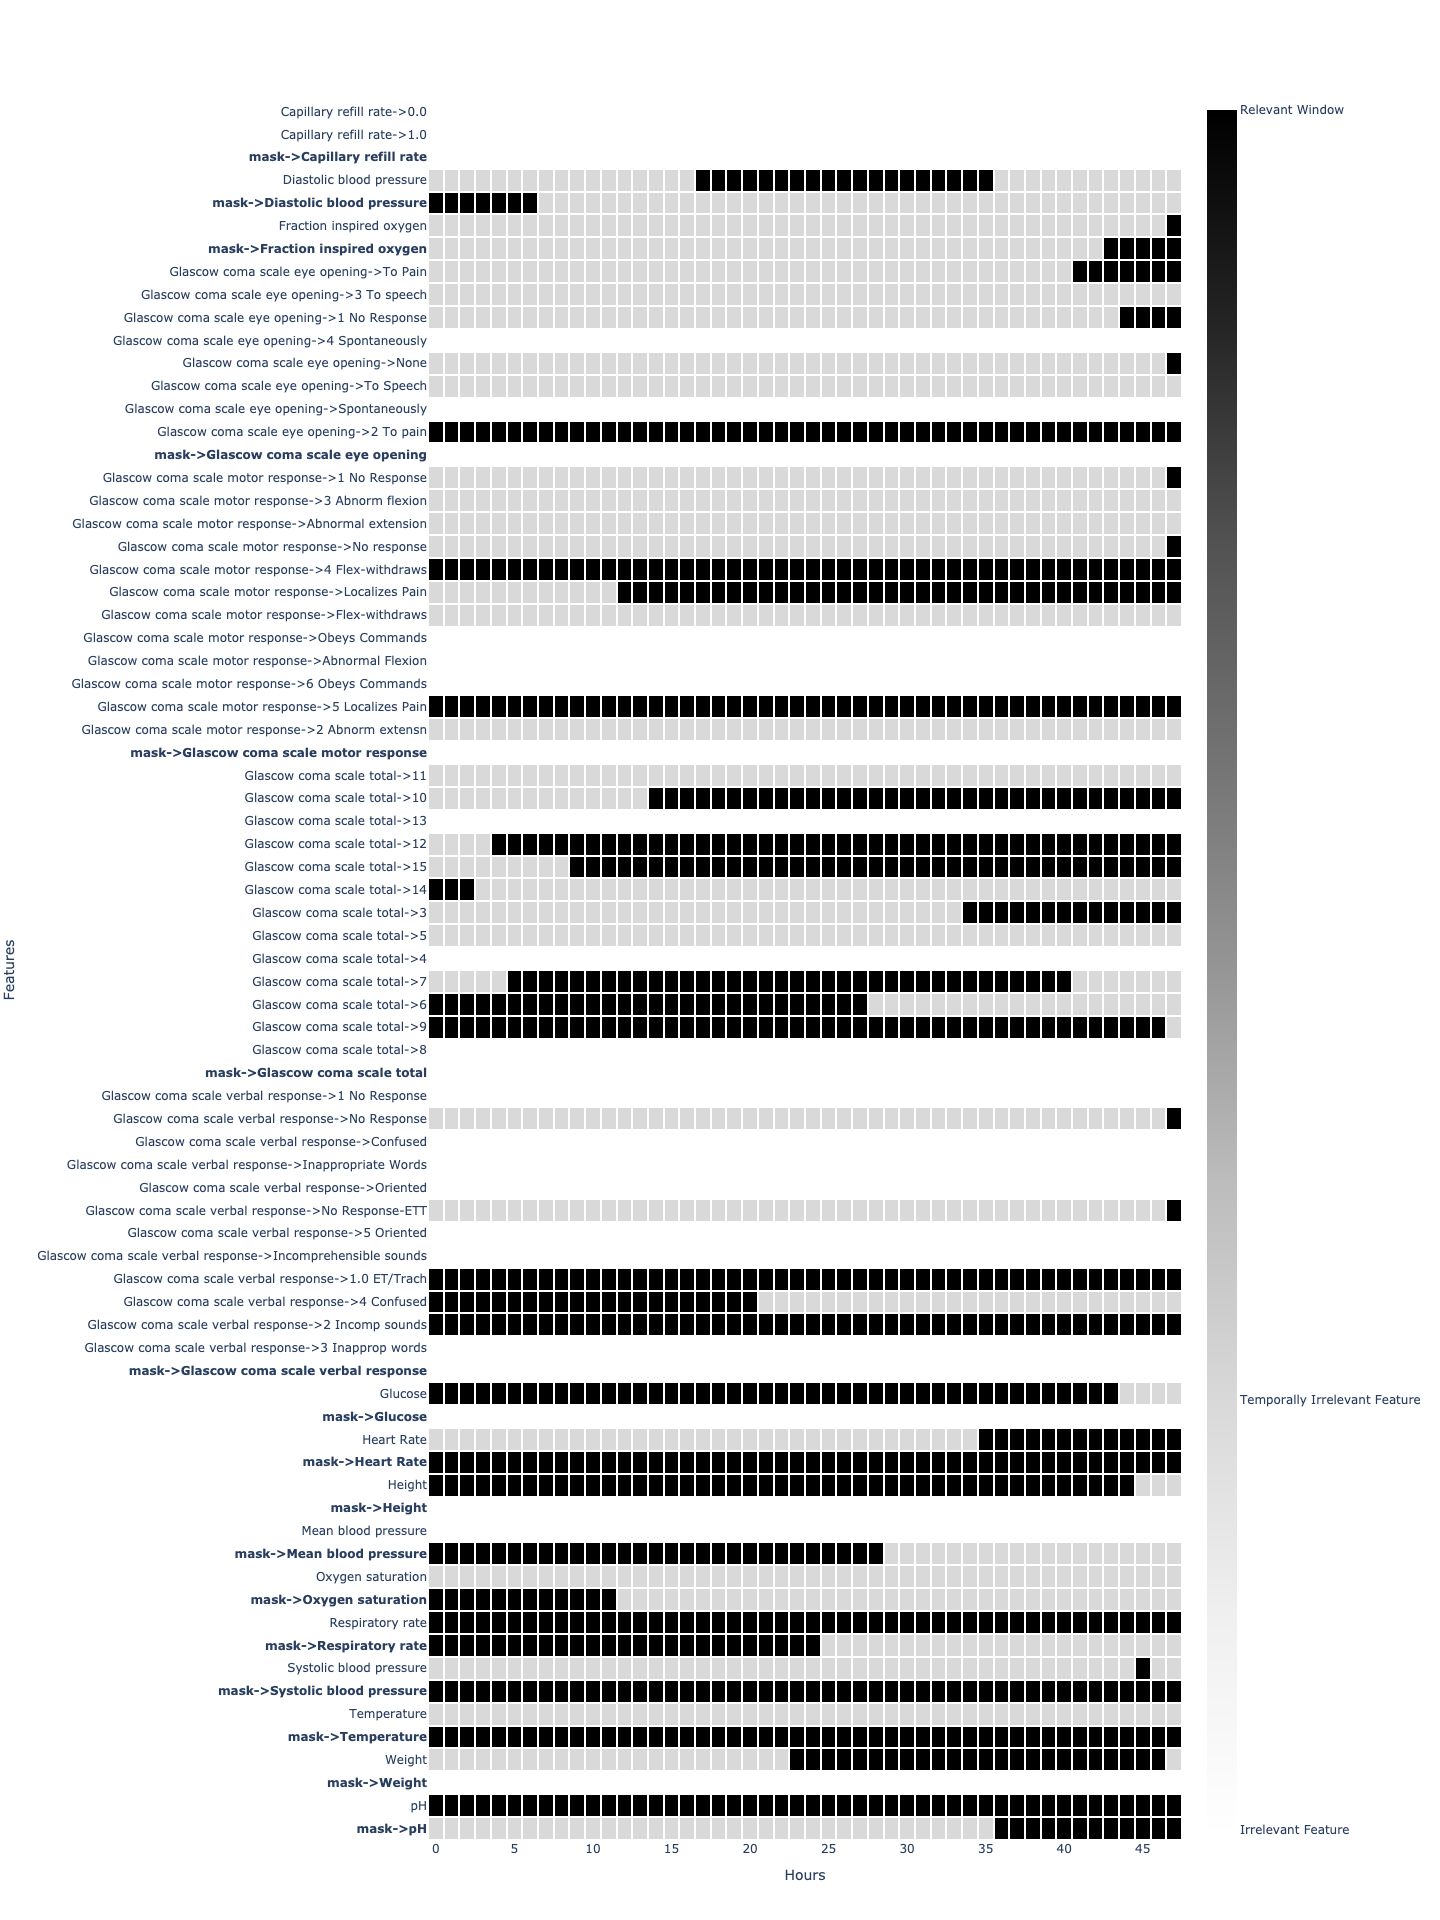

In [3]:
"""Visualize feature importance"""
import pickle
import re

import cloudpickle
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

NUM_FEATURES = 76
SEQUENCE_LENGTH = 48
INPUT_DIR = "mimic_lstm_in_hospital_mortality"


def visualize_feature_importance(features):
    """Visualize outputs"""
    data = np.zeros((NUM_FEATURES, SEQUENCE_LENGTH))
    for idx, feature in enumerate(features):
        data[idx, :] = 0
        if feature.important:
            data[idx, :] = 0.5
            if feature.temporally_important:
                left, right = feature.temporal_window
                data[idx, left: right + 1] = 2
        if feature.name.startswith("mask"):
            feature.name = f"<b>{feature.name}</b>"

    fig = go.Figure()
    fig.add_trace(go.Heatmap(z=data,
                             y=[feature.name for feature in features]))
    fig.update_traces(colorscale="Greys", showscale=True,
                      xgap=2, ygap=2,
                      colorbar=dict(tickmode="array", tickvals=[0, 0.5, 2], 
                                    ticktext=["Irrelevant\nFeature",
                                              "Temporally\nIrrelevant\nFeature",
                                              "Relevant\nWindow"]))
    
    fig.update_layout(height=1920, plot_bgcolor="white",
                      xaxis_title="Hours", yaxis_title="Features")
    # fig.show()  # Enable to get interactive plot
    img_bytes = fig.to_image(format="png", width=1440)
    display(Image(img_bytes))
    return data

with open(f"{INPUT_DIR}/features.cpkl", "rb") as features_file:
    features = cloudpickle.load(features_file)

with open(f"{INPUT_DIR}/discretizer_header.pkl", "rb") as feature_names_file:
    feature_names = pickle.load(feature_names_file)

# Features and have integer names but are not sorted
# The integers correspond to indices of feature_names
features.sort(key=lambda feature: int(feature.name))
for idx, feature in enumerate(features):
    assert idx == int(feature.name)
    assert idx == feature.idx[0]
    feature.name = feature_names[idx]
# Arrange mask features next to corresponding features
# Identify the 17 feature types
feature_types = []
for feature in features:
    match = re.match("^mask->([a-zA-Z ]+)", feature.name)
    if match is not None:
        feature_types.append(match.groups()[0])
# Re-order features
new_features = []
for feature_type in feature_types:
    for feature in features:
        if feature_type in feature.name:
            new_features.append(feature)
features = new_features
features = list(reversed(features))  # Heatmap generation starts at bottom

importance_values = visualize_feature_importance(features)

In [4]:
"""Generate trajectories"""
from collections import OrderedDict


# Load data
# Model is analyzed on test data, but we might expect to see train data trajectories match window localization
data_types = ("train", "test")
trajectory_data = OrderedDict([(data_type, None) for data_type in data_types])
for data_type in data_types:
    filename = f"{INPUT_DIR}/wdir/mimic3-benchmarks/mimic3models/in_hospital_mortality/saved/{data_type}_data.npz"
    arrs = np.load(filename)
    data = arrs["arr_0"].transpose((0, 2, 1))
    assert data.shape[2] == SEQUENCE_LENGTH
    targets = arrs["arr_1"]
    # Identify positive/negative samples
    pos_idx = np.nonzero(targets)[0]
    neg_idx = np.nonzero(targets == 0)[0]
    assert len(pos_idx) + len(neg_idx) == len(targets)
    trajectory_data[data_type] = (data, pos_idx, neg_idx)

# Pre-process features for visualization
fid_to_name_map = {feature.idx[0]: feature.name for feature in features}
fid_to_importance_map = {features[index].idx[0]: importance_value for index, importance_value in enumerate(importance_values)}
importance_to_color_map = {0: "white", 0.5: "rgb(217,217,217)", 2.0: "black"}
fids = [feature.idx[0] for feature in reversed(features)]

# Visualize trajectories
timestamps = np.arange(SEQUENCE_LENGTH)
for count, fid in enumerate(fids):
    for data_type, (data, pos_idx, neg_idx) in trajectory_data.items():
        pos_means = np.mean(data[pos_idx, fid, :], axis=0)
        pos_stds = np.std(data[pos_idx, fid, :], axis=0)
        neg_means = np.mean(data[neg_idx, fid, :], axis=0)
        neg_stds = np.std(data[neg_idx, fid, :], axis=0)
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=timestamps, y=pos_means, mode="lines", name="Pos", line_color="blue"))
        fig.add_trace(go.Scatter(x=timestamps, y=pos_means + pos_stds, mode="lines",
                                 showlegend=False, line_color="blue"))
        fig.add_trace(go.Scatter(x=timestamps, y=pos_means - pos_stds, mode="lines", fill="tonexty",
                                 showlegend=False, line_color="blue"))

        fig.add_trace(go.Scatter(x=timestamps, y=neg_means, mode="lines", name="Neg", line_color="red"))
        fig.add_trace(go.Scatter(x=timestamps, y=neg_means + neg_stds, mode="lines",
                                 showlegend=False, line_color="red"))
        fig.add_trace(go.Scatter(x=timestamps, y=neg_means - neg_stds, mode="lines", fill="tonexty",
                                 showlegend=False, line_color="red"))

        fig.update_layout(title=dict(text=f"{fid_to_name_map[fid]}: Trajectory of Mean &plusmn; SD ({data_type} data)"),
                          xaxis_title="Hours", yaxis_title="Value", template="none")
        fig.show()
    # Importance
    colors = list(map(lambda importance: importance_to_color_map[importance], fid_to_importance_map[fid]))
    fig = go.Figure()
    fig.add_trace(go.Table(header=dict(values=[""] * data.shape[1], line_color="black",
                                       fill_color=colors)))
    fig.update_layout(title=dict(text=f"{fid_to_name_map[fid]}: Relevant Window"), template="none", height=250)
    fig.show()